<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB99_group_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & import `nilearn` and `mne-nirs`

In [ ]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 61.5 MB 248 kB/s
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Google Drive

In [ ]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [ ]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Routines

In [ ]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [ ]:
#@markdown `def create_channels_table(data,reorder=False)`
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [ ]:
#@markdown `def create_channels_raw(data,reorder=False)`
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [ ]:
#@markdown `def normalize_channels(df)`
def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [ ]:
#@markdown `def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25)`
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        if df_not_scaled[c].mean() != 0:
          cv = df_not_scaled[c].std() / df_not_scaled[c].mean()
        else:
          cv = 0
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color=['gray','yellow'][cv > cv_threshold or cv == 0], alpha=[0.5,0.8][cv > cv_threshold or cv == 0])

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [ ]:
#@markdown `def check_sample_rate(df)`
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [ ]:
#@markdown `def perc_negatives(s_neg)`
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [ ]:
#@markdown `def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25)`
# from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          if df[chnames[i]].min() < 0:          
            plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
          else:
            if df[chnames[i]].mean() != 0:
              cv = df[chnames[i]].std() / df[chnames[i]].mean()
            else:
              cv = 0  
            plt.plot(df.time, df[chnames[i]], color=['blue','yellow'][cv > cv_threshold or cv == 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

      print()
      print('Coeficientes de Variação, Threshold = ', cv_threshold, ' e Presença de Valores Negativos')
      
      cv_list = [] # 0 for channels with all values 0 (invalid)
      for c in channels_raw.drop(columns = 'time'):
        if channels_raw.drop(columns = 'time')[c].mean() != 0:
          cv_list.append( channels_raw.drop(columns = 'time')[c].std() / channels_raw.drop(columns = 'time')[c].mean() )
        else:
          cv_list.append(0)  
      df_cv = pd.DataFrame( channels_raw.drop(columns = 'time').std() ) # just to inicialize df
      df_cv.rename(columns={0:'coef_var'},inplace=True)
      df_cv['coef_var'] = cv_list # replace with real cvs
      df_cv['up_threshold'] = df_cv['coef_var'] > cv_threshold
      df_cv['negative_values'] = channels_raw.drop(columns = 'time').min() < 0
      print(df_cv)

      print()
      print('*Coeficientes de Variação é válido somente para valores positivos')

  return



In [ ]:
#@markdown `def interpolate_negatives(s_neg, threshold_neg = 0.10)`
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [ ]:
#@markdown `def rectify_negatives(df, threshold_neg = 0.10, transform='zeros')`
def rectify_negatives(df, threshold_neg = 0.10, transform='zeros'):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      if transform == 'zeros':
        df[c] = 0
        print(c,'\t...had values transformed to zeros')
      elif transform == 'positive':
        df[c] = df[c] + np.abs(df[c].min())
        print(c,'\t...had values rescaled to positive')  
      else:
        print('parameter transform erro. Only transforms negatives values to "zeros" or "positive" available up to now')  
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [ ]:
#@markdown `def add_appname_snirf(data, appname='snirf-Mack')`
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [ ]:
#@markdown `def rectify_negatives_snirf(data, channels_raw, rectified_negatives)` 
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [ ]:
#@markdown `def rectify_time_snirf(data, channels_raw)`
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [ ]:
#@markdown `def create_stim_from_aux(data,delete_before=False,show=None)`
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [ ]:
#@markdown `def plot_aux_stimulus(data)`
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

In [ ]:
#@markdown `def rectify_stim_duration(data,duration=5,show=None)`
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [ ]:
#@markdown `def create_stim_rest(data,show=True)`
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [ ]:
#@markdown `def plot_stim_stimulus(data)`
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

In [ ]:
#@markdown def rectity_split_stims(data,check=False)
def rectity_split_stims(data,check=False):

  if check: print(data['nirs'].keys())
  for s in ['stim1', 'stim3', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05']:
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # rename
  for s in ['stim2','stim4','stim5']:
  #  data['nirs'].create_group(s + 'old') 
    data['nirs'].copy(s, 'old' + s)
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # create splitted stimulus
  labels = data['nirs']['oldstim2']['dataLabels'][:]
  stim_nr = 1
  for s in ['oldstim2','oldstim4','oldstim5']:
    for i in range(len(data['nirs'][s]['data'][:])):
      stim = 'stim' + str(stim_nr)
      data['nirs'].create_group(stim)
      data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][s]['name'][0].decode('UTF-8') + str(i+1)]).astype('|S10'))
      data['nirs'][stim].create_dataset('dataLabels', data=labels)
      data['nirs'][stim].create_dataset('data', data=data['nirs'][s]['data'][i][np.newaxis,:]) 
      stim_nr = stim_nr + 1 
  if check: print(data['nirs'].keys())

  # check
  if check:
    stim_list = [x for x in data['nirs'].keys() if ('stim' in x) and ('old' not in x)]
    stim_names = []
    stim_start = []

    for s in stim_list:
      stim_names.append(data['nirs'][s]['name'][0].decode('utf8')) 
      stim_start.append(data['nirs'][s]['data'][:][0][0])

    print(pd.DataFrame({'stim_names': stim_names, 'stim_start':stim_start},index=None).sort_values('stim_start').head())

  # delete old ones
  del data['nirs']['oldstim2']
  del data['nirs']['oldstim4']
  del data['nirs']['oldstim5']

  # data.close()
  return


# Copia todos arquivos do drive para local

In [ ]:
import os
path_in = '/content/drive/MyDrive/cond 1/snirf/'
# path_in = '/content/drive/MyDrive/Cond 2/snirf/'

if 'cond 1' in path_in:
  condicao = 1
else:
  condicao = 2



In [ ]:
#@markdown def plt_hemo(raw_haemo=raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2')
def plt_hemo(raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2'):
  evoked_dict_Sync = {'Sync/HbO': epochs[e1].average(picks='hbo'),
                'Sync/HbR': epochs[e1].average(picks='hbr'),
                'controle/HbO': epochs[c1].average(picks='hbo'),
                'controle/HbR': epochs[c1].average(picks='hbr')}

  evoked_dict_Async = {'Async/HbO': epochs[e2].average(picks='hbo'),
                'Async/HbR': epochs[e2].average(picks='hbr'),
                'controle/HbO': epochs[c2].average(picks='hbo'),
                'controle/HbR': epochs[c2].average(picks='hbr')}
  # print(evoked_dict_Sync)
  # print(evoked_dict_Sync)

  color_dict = dict(HbO='#AA3377', HbR='b')
  styles_dict = dict(controle=dict(linestyle='dashed'))

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  # Rename channels until the encoding of frequency in ch_name is fixed
  evoked_dict = evoked_dict_Sync
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4]) # retira hbo e hbr do suffixo dos nomes      
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e1 + ' X ' + c1)
  print('*' + 70*'-')
  fig1 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                                colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig1[0].savefig(subject+'_Sync.png')
  plt.show()

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  evoked_dict = evoked_dict_Async
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4])        
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e2 + ' X ' + c2)
  print('*' + 70*'-')
  fig2 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                              colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig2[0].savefig(subject+'_Async.png')
  plt.show()

  return



['25_run1.snirf']
Loading /content/drive/MyDrive/cond 1/snirf/25_run1.snirf
Reading 0 ... 21724  =      0.000 ...  2172.400 secs...


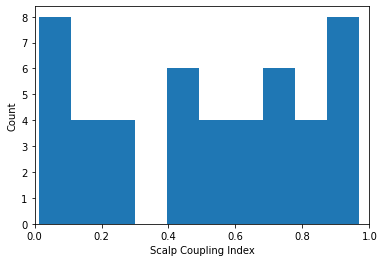

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


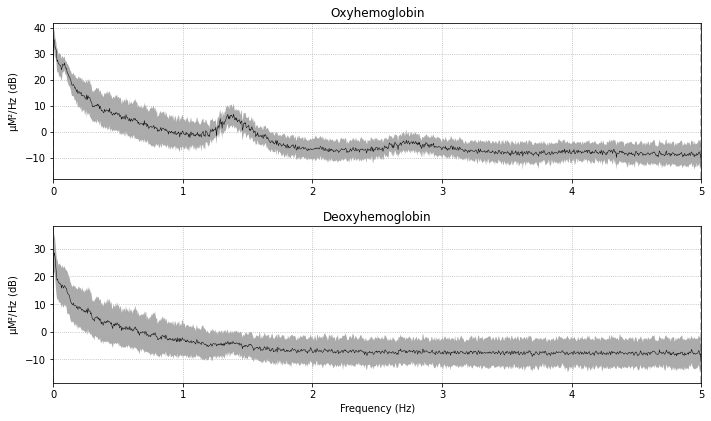

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.2s finished


Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


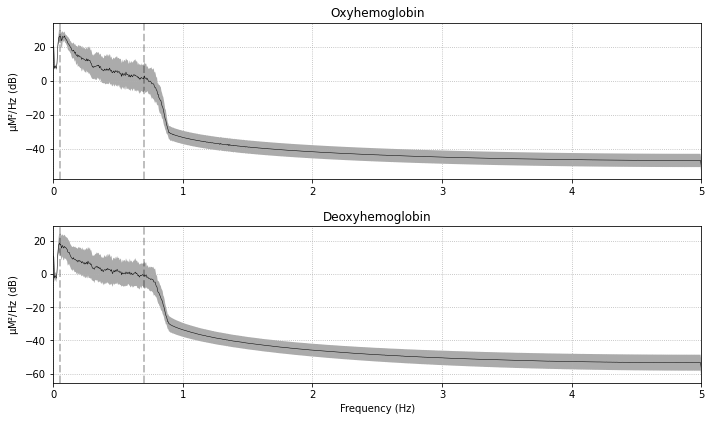

<Info | 10 non-empty values
 bads: 26 items (S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 ...)
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:52 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


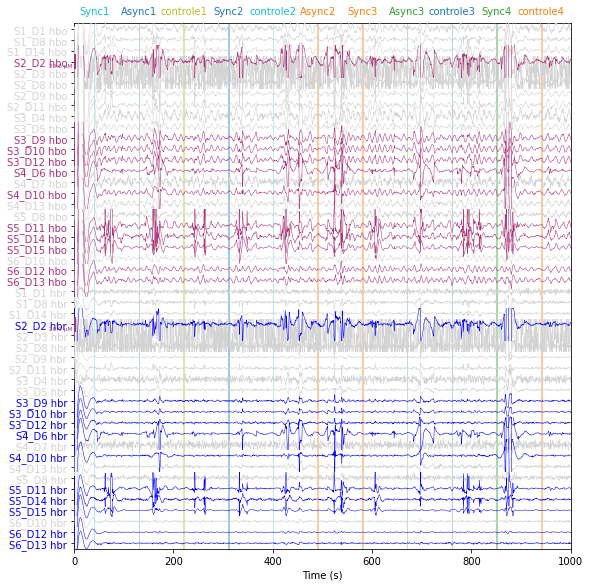

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
24 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 201 original time points ...
0 bad epochs dropped


<ipython-input-112-4009290be460>:75: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  sfreq=raw_haemo.info['sfreq'])


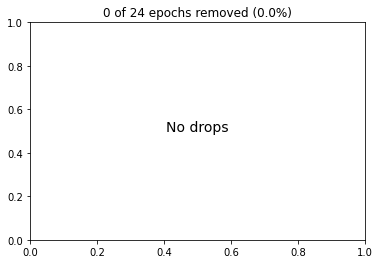

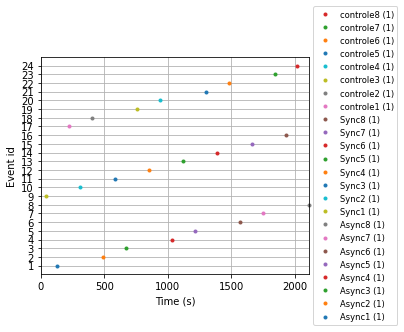

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


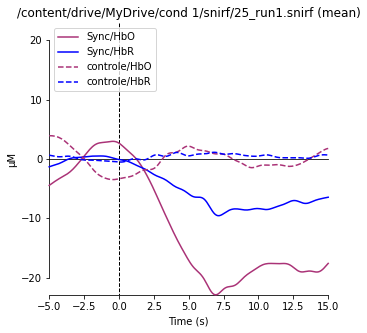

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


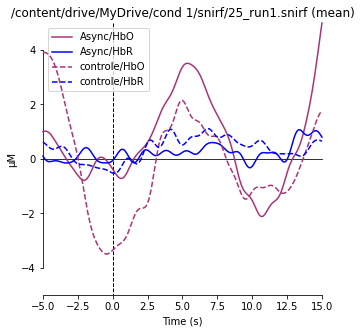

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


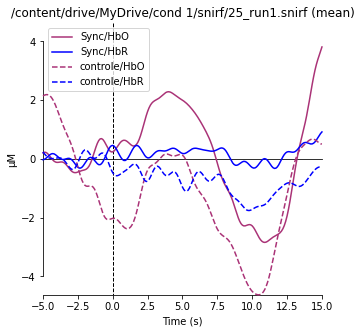

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


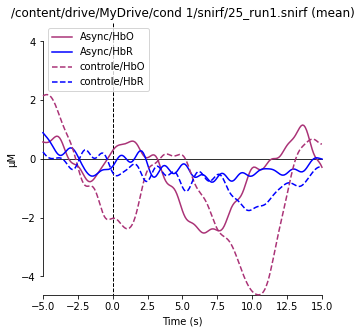

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


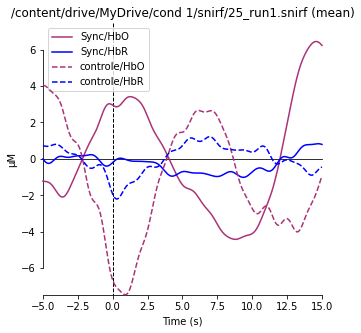

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


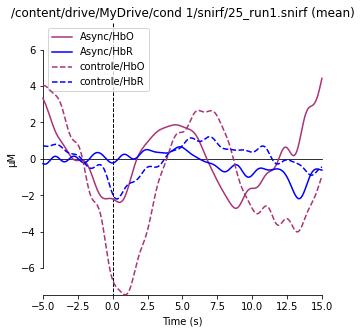

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


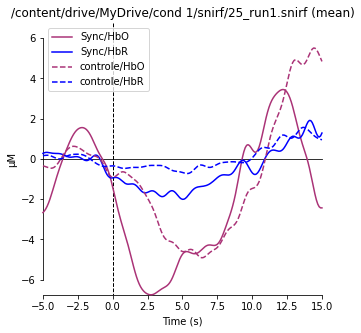

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


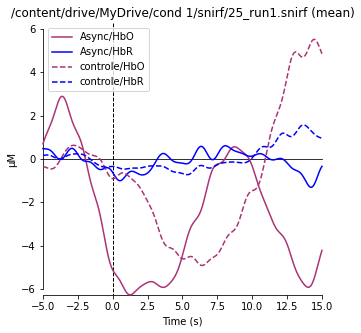

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


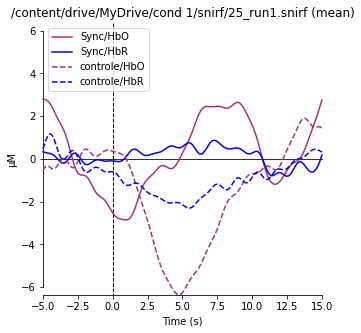

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


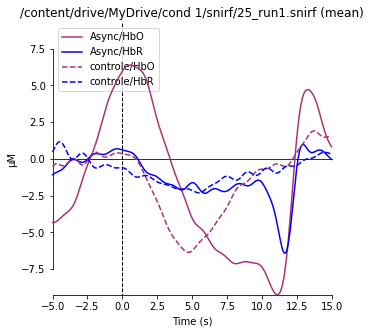

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


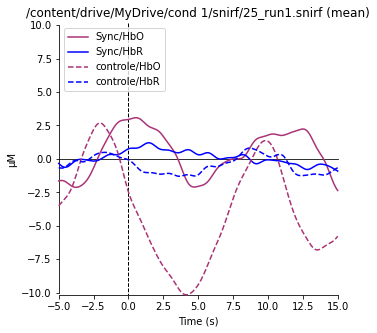

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


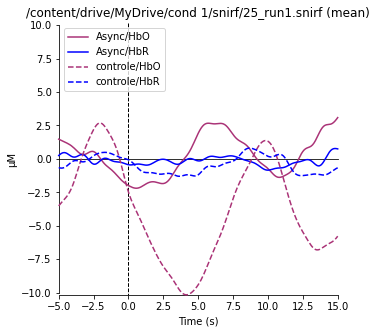

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


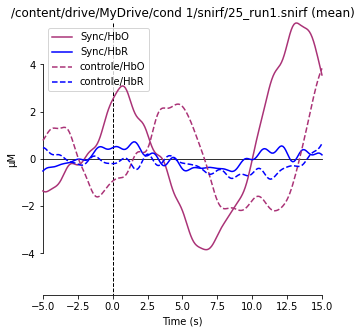

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


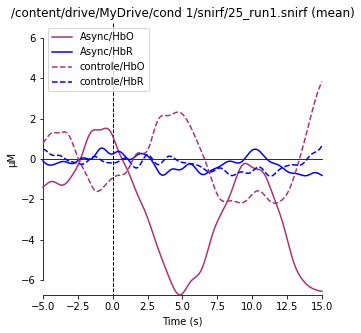

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Sync8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


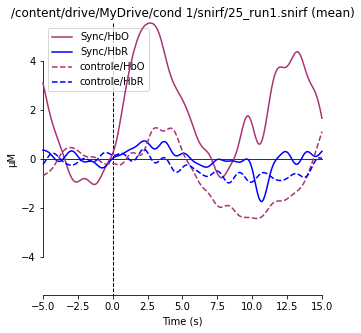

*
* /content/drive/MyDrive/cond 1/snirf/25_run1.snirf Async8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


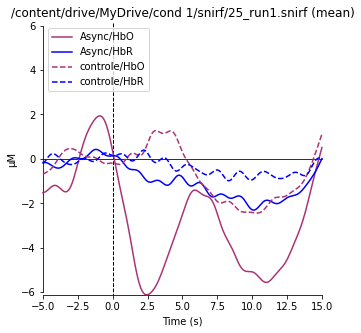

In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law, 
                                  temporal_derivative_distribution_repair)
import mne
import pickle

threshold = 0.6 # FOR bad_list... se você tiver uma trocar!

# entries = [subject + '.snirf']
if condicao == 1:
  # entries_sample = [ entries[4] ]
  entries_sample = [ '25_run1.snirf' ]
else:
  # entries_sample = [ entries[1] ]
  entries_sample = [ '28_run2.snirf' ]

print(entries_sample)

sci_df_exists = False
sci_df = pd.DataFrame()

for fname in entries_sample:
  raw_intensity = mne.io.read_raw_snirf(path_in + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  fig, ax = plt.subplots()
  ax.hist(sci)
  ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
  plt.show()
  
  raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < threshold))
  # raw_od.info['bads'] = list(bad_list)

  '''
  raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
  raw_haemo.resample(0.3)
  '''

  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('Before filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                              l_trans_bandwidth=0.02)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('After filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  plt.show()

  print(raw_haemo.info)

  raw_haemo.plot(n_channels=48, duration=1000, show_scrollbars=False)
  plt.show()

  events, event_dict = mne.events_from_annotations(raw_haemo)

  # events, _ = mne.events_from_annotations(raw_haemo)
  # event_dict = {'Async': 2, 'Sync': 3, 'controle': 4}

  reject_criteria = dict(hbo=80e-6)
  tmin, tmax = -5, 15

  epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                      tmin=tmin, tmax=tmax,
  #                   reject=reject_criteria, 
                      reject_by_annotation=True,
                      proj=True, baseline=(None, 0), preload=True,
                      detrend=None, verbose=True,
                      event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
  epochs.plot_drop_log()

  fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
  fig.subplots_adjust(right=0.7)  # make room for the legend

  for i in range(8):
    n = str(i+1)
    plt_hemo(raw_haemo=raw_haemo, e1='Sync'+n, c1='controle'+n, e2='Async'+n, c2='controle'+n)


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"


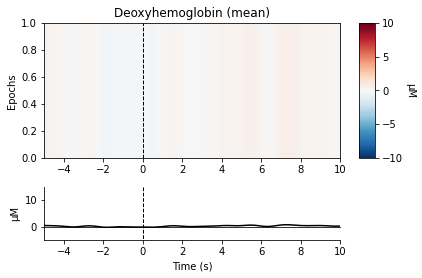

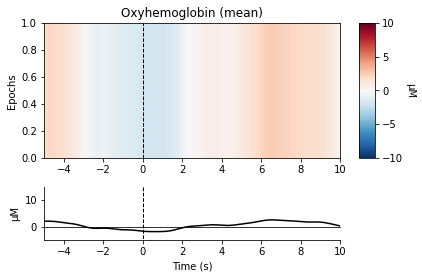

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [ ]:
epochs['Sync5'].plot_image(combine='mean', vmin=-10, vmax=10,
                             ts_args=dict(ylim=dict(hbo=[-5, 15],
                                                    hbr=[-5, 15])))

No projector specified for this dataset. Please consider the method self.add_proj.


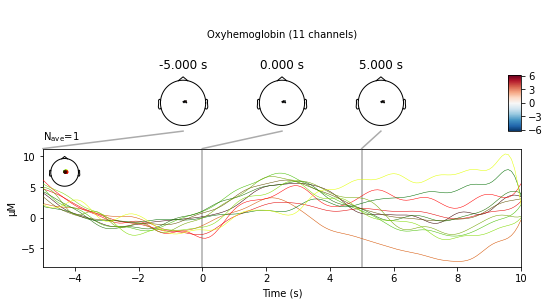

In [ ]:
times = np.arange(-5, 10, 5.0)
topomap_args = dict(extrapolate='local')
epochs['Sync8'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args)
plt.show()

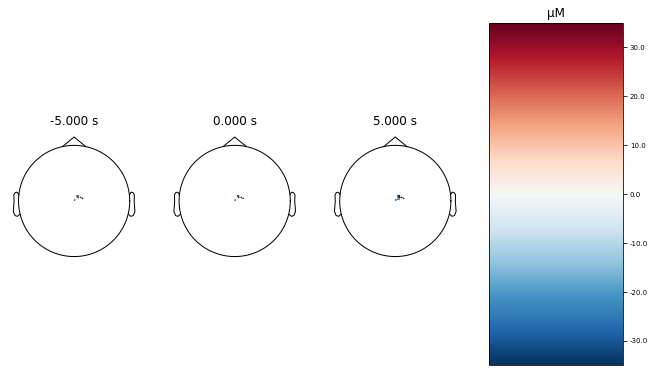

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(9, 5))

epochs['Sync1'].average(picks='hbo').plot_topomap(
    times=times, axes=axes, **topomap_args)
epochs['controle1'].average(picks='hbo').plot_topomap(
    times=times, axes=axes, **topomap_args)
plt.show()

In [ ]:
epochs_df = epochs.to_data_frame()
epochs_df.head()

,time,condition,epoch,S1_D1 hbo,S1_D1 hbr,S1_D8 hbo,S1_D8 hbr,S1_D14 hbo,S1_D14 hbr,S2_D2 hbo,...,S5_D14 hbo,S5_D14 hbr,S5_D15 hbo,S5_D15 hbr,S6_D10 hbo,S6_D10 hbr,S6_D12 hbo,S6_D12 hbr,S6_D13 hbo,S6_D13 hbr
0,-5000,Sync1,0,-5.953831,-1.182923,-3.417402,-2.920443,-4.118948,-1.101390,-7.550697,...,-5.455799,-0.531131,-3.117316,-1.041383,-4.936593,-1.389182,-4.185523,-1.186735,-3.945893,-1.375819
1,-4900,Sync1,0,-5.434572,-1.293229,-3.274489,-2.888806,-4.089092,-0.739846,-7.349016,...,-5.260736,-0.237630,-2.891571,-0.977349,-4.862550,-1.106612,-3.979362,-1.102084,-3.890876,-1.214214
2,-4800,Sync1,0,-4.939839,-1.360506,-3.203042,-2.739342,-4.087610,-0.295632,-7.166363,...,-5.035228,0.024645,-2.677821,-0.894547,-4.699463,-0.930568,-3.802234,-1.005511,-3.875765,-1.045386
3,-4700,Sync1,0,-4.491262,-1.404359,-3.183918,-2.499650,-4.092108,0.185903,-6.971210,...,-4.769983,0.222561,-2.479511,-0.794198,-4.454952,-0.859604,-3.658916,-0.894995,-3.900293,-0.866814
4,-4600,Sync1,0,-4.106202,-1.437891,-3.193573,-2.205431,-4.074111,0.648308,-6.732781,...,-4.465459,0.337426,-2.299666,-0.679926,-4.153458,-0.869306,-3.550092,-0.770924,-3.957719,-0.676687


In [ ]:
bad_list = {}
for col in epochs_df.drop(columns=['time','condition','epoch']):
  if 'hbo' in col:
    bad_list[col] = {}
    for i in range(1,9):
      bad_list[col]['Sync' + str(i)] = epochs_df[ epochs_df.condition == 'Sync' + str(i) ][col].mean() - epochs_df[ epochs_df.condition == 'controle' + str(i)  ][col].mean()
      
bad_list


{'S1_D1 hbo': {'Sync1': -5.864529318784989,
  'Sync2': 2.519845919322323,
  'Sync3': -0.6338185213223932,
  'Sync4': -0.11124718940193046,
  'Sync5': -0.07082749513722887,
  'Sync6': 1.2103707289232664,
  'Sync7': -0.3944041880659863,
  'Sync8': 1.3623737806087102},
 'S1_D14 hbo': {'Sync1': -8.642363504937205,
  'Sync2': 0.15671992795558892,
  'Sync3': -2.9638841108345817,
  'Sync4': -1.468908191769291,
  'Sync5': 3.0364837104807223,
  'Sync6': 3.0260718323670948,
  'Sync7': 1.0451484400312965,
  'Sync8': 0.8057308889763781},
 'S1_D8 hbo': {'Sync1': -5.7056828688958765,
  'Sync2': 2.0638041711462076,
  'Sync3': -0.5525842927176217,
  'Sync4': -1.838352463726115,
  'Sync5': 1.0080061574549564,
  'Sync6': 0.1852723497145352,
  'Sync7': 2.171846153326445,
  'Sync8': 0.5105057710212509},
 'S2_D11 hbo': {'Sync1': -7.115340332206722,
  'Sync2': 0.30336352787316456,
  'Sync3': 0.7433577039576672,
  'Sync4': 0.4447975824724355,
  'Sync5': 1.8155640212938204,
  'Sync6': 3.6967281766798044,
  'S

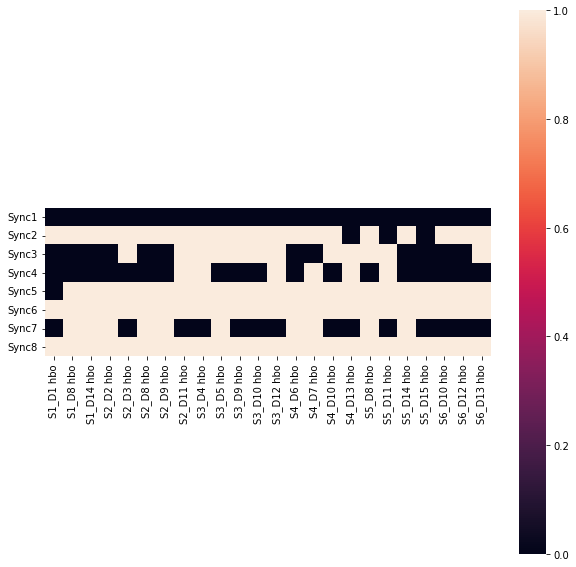

In [ ]:
plt.figure(figsize=(10,10))

sns.heatmap(pd.DataFrame(bad_list) > 0,square=True, cbar=True)
plt.show()

In [ ]:
pd.DataFrame( pd.DataFrame(bad_list) > 0 ).mean().sort_values()

S1_D1 hbo     0.375
S5_D15 hbo    0.375
S6_D10 hbo    0.500
S6_D12 hbo    0.500
S5_D14 hbo    0.625
S5_D11 hbo    0.625
S4_D13 hbo    0.625
S4_D10 hbo    0.625
S4_D6 hbo     0.625
S3_D9 hbo     0.625
S3_D10 hbo    0.625
S2_D9 hbo     0.625
S2_D8 hbo     0.625
S2_D3 hbo     0.625
S2_D2 hbo     0.625
S1_D14 hbo    0.625
S1_D8 hbo     0.625
S6_D13 hbo    0.625
S3_D4 hbo     0.750
S3_D12 hbo    0.750
S2_D11 hbo    0.750
S4_D7 hbo     0.750
S5_D8 hbo     0.750
S3_D5 hbo     0.750
dtype: float64

In [ ]:
good_list = ['S3_D4', 'S3_D12', 'S2_D11', 'S4_D7', 'S5_D8', 'S3_D5'] 

bad_list = [ x for x in epochs_df.columns[3::] if x.split(' ')[0] not in good_list]
bad_list

for i in range(len(bad_list)):
  bad_list[i] = bad_list[i].replace('hbo','685')
  bad_list[i] = bad_list[i].replace('hbr','830')

bad_list


['S1_D1 685',
 'S1_D1 830',
 'S1_D8 685',
 'S1_D8 830',
 'S1_D14 685',
 'S1_D14 830',
 'S2_D2 685',
 'S2_D2 830',
 'S2_D3 685',
 'S2_D3 830',
 'S2_D8 685',
 'S2_D8 830',
 'S2_D9 685',
 'S2_D9 830',
 'S3_D9 685',
 'S3_D9 830',
 'S3_D10 685',
 'S3_D10 830',
 'S4_D6 685',
 'S4_D6 830',
 'S4_D10 685',
 'S4_D10 830',
 'S4_D13 685',
 'S4_D13 830',
 'S5_D11 685',
 'S5_D11 830',
 'S5_D14 685',
 'S5_D14 830',
 'S5_D15 685',
 'S5_D15 830',
 'S6_D10 685',
 'S6_D10 830',
 'S6_D12 685',
 'S6_D12 830',
 'S6_D13 685',
 'S6_D13 830']

In [ ]:
len(raw_haemo.info['bads'])

26

In [ ]:
len( epochs_df.columns ) - 3

48

In [ ]:
# Import MNE-NIRS processing
from mne_nirs.statistics import run_glm
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.channels import get_short_channels, get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.io.fold import fold_channel_specificity

# Import MNE-BIDS processing
# from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

# Import StatsModels
import statsmodels.formula.api as smf

def individual_analysis(bids_path, ID):

    raw_intensity = mne.io.read_raw_snirf(path_in + fname, verbose=True)
    # sanitize event names
    raw_intensity.annotations.description[:] = [
        d.replace('/', '_') for d in raw_intensity.annotations.description]

    # Convert signal to haemoglobin and resample
    raw_od = optical_density(raw_intensity)
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo.resample(0.3)

    # Cut out just the short channels for creating a GLM repressor
    # sht_chans = get_short_channels(raw_haemo)
    # raw_haemo = get_long_channels(raw_haemo)

    # Create a design matrix
    design_matrix = make_first_level_design_matrix(raw_haemo, stim_dur=5.0)

    # Append short channels mean to design matrix
    # design_matrix["ShortHbO"] = np.mean(sht_chans.copy().pick(picks="hbo").get_data(), axis=0)
    # design_matrix["ShortHbR"] = np.mean(sht_chans.copy().pick(picks="hbr").get_data(), axis=0)

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)

    # Define channels in each region of interest
    # List the channel pairs manually
    left = [[4, 3], [1, 3], [3, 3], [1, 2], [2, 3], [1, 1]]
    right = [[8, 7], [5, 7], [7, 7], [5, 6], [6, 7], [5, 5]]
    # Then generate the correct indices for each pair
    groups = dict(
        Left_Hemisphere=picks_pair_to_idx(raw_haemo, left, on_missing='ignore'),
        Right_Hemisphere=picks_pair_to_idx(raw_haemo, right, on_missing='ignore'))

    # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(groups,
                                                  design_matrix.columns,
                                                  demographic_info=True)

    # Define left vs right tapping contrast
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
    contrast_LvR = basic_conts['Sync1'] - basic_conts['controle1']

    # Compute defined contrast
    contrast = glm_est.compute_contrast(contrast_LvR)
    con = contrast.to_dataframe()

    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = con["ID"] = ID

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.e6 for t in roi["theta"]]
    con["effect"] = [t * 1.e6 for t in con["effect"]]

    return raw_haemo, roi, cha, con

individual_analysis(None, fname)

Loading /content/drive/MyDrive/cond 1/snirf/25_run1.snirf
Reading 0 ... 21724  =      0.000 ...  2172.400 secs...


(<RawSNIRF | 25_run1.snirf, 48 x 652 (2170.0 s), ~316 kB, data loaded>,
                 ROI Condition Chroma        theta           se          t  \
 0   Left_Hemisphere    Async1    hbo   144.994703   902.870177   0.160593   
 1   Left_Hemisphere    Async1    hbr   180.090771   277.595381   0.648753   
 0   Left_Hemisphere    Async2    hbo   493.565141   905.167202   0.545275   
 1   Left_Hemisphere    Async2    hbr    91.409563   278.218528   0.328553   
 0   Left_Hemisphere    Async3    hbo   797.275437   905.117822   0.880853   
 ..              ...       ...    ...          ...          ...        ...   
 1   Left_Hemisphere  drift_42    hbr   409.963551   400.236688   1.024303   
 0   Left_Hemisphere  drift_43    hbo  1972.520661  1222.771873   1.613155   
 1   Left_Hemisphere  drift_43    hbr   458.611487   400.124788   1.146171   
 0   Left_Hemisphere  constant    hbo  -161.275693    48.020133  -3.358502   
 1   Left_Hemisphere  constant    hbr   218.409227    15.798772  13.82

In [ ]:
df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con = pd.DataFrame()  # To store channel level contrast results

for sub in entries_sample:  # Loop from first to fifth subject

    # Create path to file based on experiment info
    # bids_path = dataset.update(subject=sub)

    # Analyse data and return both ROI and channel results
    raw_haemo, roi, channel, con = individual_analysis(None, sub)

    # Append individual results to all participants
    df_roi = pd.concat([df_roi, roi], ignore_index=True)
    df_cha = pd.concat([df_cha, channel], ignore_index=True)
    df_con = pd.concat([df_con, con], ignore_index=True)

Loading /content/drive/MyDrive/cond 1/snirf/25_run1.snirf
Reading 0 ... 21724  =      0.000 ...  2172.400 secs...


In [ ]:
!pip install lets_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 8.6 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 


In [ ]:
# Import Plotting Library
import matplotlib.pyplot as plt
import matplotlib as mpl
from lets_plot import *
LetsPlot.setup_html()

grp_results = df_roi.query("Condition in ['Sync1', 'Async1', 'controle1', 'Sync6', 'Async6', 'controle6']")
grp_results = grp_results.query("Chroma in ['hbo']")

ggplot(grp_results, aes(x='Condition', y='theta', color='ROI', shape='ROI')) \
    + geom_hline(y_intercept=0, linetype="dashed", size=1) \
    + geom_point(size=5) \
    + facet_grid('ID') \
    + ggsize(900, 350)

In [ ]:
df_con

variable,ContrastType,effect,p_value,stat,z_score,Source,Detector,Chroma,Significant,ch_name,ID
0,t,-81.513381,0.533807,-0.084880,-0.084843,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
1,t,-121.395314,0.704662,-0.538154,-0.537857,1,1,hbr,False,S1_D1 hbr,25_run1.snirf
2,t,113.964277,0.447199,0.132799,0.132741,1,8,hbo,False,S1_D8 hbo,25_run1.snirf
3,t,13.262453,0.487172,0.032173,0.032159,1,8,hbr,False,S1_D8 hbr,25_run1.snirf
4,t,484.311206,0.315460,0.480686,0.480433,1,14,hbo,False,S1_D14 hbo,25_run1.snirf
5,t,130.445672,0.339513,0.414000,0.413793,1,14,hbr,False,S1_D14 hbr,25_run1.snirf
6,t,-379.988941,0.586103,-0.217628,-0.217531,2,2,hbo,False,S2_D2 hbo,25_run1.snirf
7,t,-451.770120,0.678666,-0.464214,-0.463973,2,2,hbr,False,S2_D2 hbr,25_run1.snirf
8,t,-953.801108,0.687407,-0.488773,-0.488513,2,3,hbo,False,S2_D3 hbo,25_run1.snirf
9,t,1385.881882,0.193244,0.866653,0.866003,2,3,hbr,False,S2_D3 hbr,25_run1.snirf


In [ ]:
ch_summary[ ch_summary.Significant == False ]

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name,ID
0,Async1,68.0,5.232176e-07,0.938960,0.000673,-0.076861,-51.732437,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
5,Async6,68.0,5.232176e-07,0.557556,0.000675,0.589385,397.743846,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
8,Sync1,68.0,5.232176e-07,0.603665,0.000674,-0.521570,-351.348758,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
13,Sync6,68.0,5.232176e-07,0.984983,0.000675,-0.018891,-12.751855,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
17,controle1,68.0,5.232176e-07,0.690438,0.000675,-0.399962,-269.835377,1,1,hbo,False,S1_D1 hbo,25_run1.snirf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,Async6,68.0,3.677419e-07,0.637985,0.000537,0.472638,253.895156,6,13,hbo,False,S6_D13 hbo,25_run1.snirf
3136,Sync1,68.0,3.677419e-07,0.214590,0.000536,1.252743,671.597455,6,13,hbo,False,S6_D13 hbo,25_run1.snirf
3141,Sync6,68.0,3.677419e-07,0.848266,0.000537,-0.192062,-103.203074,6,13,hbo,False,S6_D13 hbo,25_run1.snirf
3145,controle1,68.0,3.677419e-07,0.952299,0.000537,0.060041,32.243093,6,13,hbo,False,S6_D13 hbo,25_run1.snirf


In [ ]:
ch_summary = df_cha.query("Condition in ['Sync1', 'Async1', 'controle1', 'Sync6', 'Async6', 'controle6']")
ch_summary = ch_summary.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
ch_model = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                       ch_summary, groups=ch_summary["ID"]).fit(method='nm')

# Here we can use the order argument to ensure the channel name order
ch_model_df = statsmodels_to_results(ch_model,
                                     order=raw_haemo.copy().pick(
                                         picks="hbo").ch_names)
# And make the table prettier
ch_model_df.reset_index(drop=True, inplace=True)
ch_model_df = ch_model_df.set_index(['ch_name', 'Condition'])
ch_model_df

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1441: RuntimeWarning: divide by zero encountered in log
  np.log(self.n_totobs - self.k_fe) / 2.)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:1441: RuntimeWarning: invalid value encountered in double_scalars
  np.log(self.n_totobs - self.k_fe) / 2.)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = 0.000000
  warnings.warn(msg, ConvergenceWarning)
/usr/

LinAlgError: ignored

# Save Selected

In [ ]:
selected_sub

['6_run2',
 '36_run2',
 '19_run2',
 '31_run2',
 '13_run2',
 '28_run2',
 '21_run2',
 '5_run2',
 '11_run2',
 '27_run2',
 '35_run2',
 '12_run2',
 '26_run2',
 '23_run2']

In [ ]:
good_list

['S1_D1 685',
 'S1_D1 830',
 'S2_D8 685',
 'S2_D8 830',
 'S4_D10 685',
 'S4_D10 830',
 'S4_D13 685',
 'S4_D13 830',
 'S4_D6 685',
 'S4_D6 830',
 'S5_D11 685',
 'S5_D11 830',
 'S5_D14 685',
 'S5_D14 830',
 'S5_D15 685',
 'S5_D15 830',
 'S5_D8 685',
 'S5_D8 830',
 'S6_D12 685',
 'S6_D12 830',
 'S6_D13 685',
 'S6_D13 830']

In [ ]:
bad_list

['S1_D14 685',
 'S1_D14 830',
 'S1_D8 685',
 'S1_D8 830',
 'S2_D11 685',
 'S2_D11 830',
 'S2_D2 685',
 'S2_D2 830',
 'S2_D3 685',
 'S2_D3 830',
 'S2_D9 685',
 'S2_D9 830',
 'S3_D10 685',
 'S3_D10 830',
 'S3_D12 685',
 'S3_D12 830',
 'S3_D4 685',
 'S3_D4 830',
 'S3_D5 685',
 'S3_D5 830',
 'S3_D9 685',
 'S3_D9 830',
 'S4_D7 685',
 'S4_D7 830',
 'S6_D10 685',
 'S6_D10 830']

In [ ]:
# ajustado 'not in good_list' para 'in good_list' 2022.05.30

channel_SD_selected = channel_SD[ channel_SD.channel_name.isin([x.split(' ')[0] for x in set(raw_od.ch_names) if x in good_list]) ].sort_values('channel_type')
channel_SD_selected

,channel_name,channel_type,channel_hole
1,S1_D8,Motor,Hole9(D8-B2)
2,S1_D14,Motor,Hole20(D6-B3)
3,S2_D2,Motor,Hole2(B2-D2)
4,S2_D3,Motor,Hole3(B2-D3)
6,S2_D9,Motor,Hole13(D1-B3)
10,S3_D9,Motor,hole13(D1-B3)
7,S2_D11,Parietal,Hole16(D3-B3)
8,S3_D4,Parietal,Hole4(D4-B2)
9,S3_D5,Parietal,Hole5(D5-B2)
11,S3_D10,Parietal,Hole14(D2-B3)


In [ ]:
path_in

'/content/drive/MyDrive/Cond 2/snirf/'

In [ ]:
import pickle

selected_sub_channels = {'selected_sub' : selected_sub, 'good_list': good_list , 'bad_list': bad_list, 'channel_SD_selected':channel_SD_selected }

# To retrieve pickle
filename = path_in + 'selected_sub_channels.pickle'
outfile = open(filename,'wb')
pickle.dump(selected_sub_channels,outfile)
outfile.close()

# To retrieve pickle
# infile = open(filename,'rb')
# new_dict = pickle.load(infile)
# infile.close()

selected_sub_channels.keys()

dict_keys(['selected_sub', 'good_list', 'bad_list', 'channel_SD_selected'])